In [43]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'

from pyspark.sql.functions import when, udf, col, regexp_replace
from pyspark.sql.types import DoubleType,IntegerType, StringType
import pyspark.sql.functions as F

In [3]:
sc = SparkContext('local')
sqlCtx = SQLContext(sc)

In [6]:
titanic = sqlCtx.read.csv( '../data/titanic1.csv', header=True,inferSchema=True )
titanic.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|
|       0|     3|33.0|    0|    0| 8.4583|          0|    1|      0.0|           2.0|          0.0|
|       0|     1|54.0|    0|    0|51.8625|          0|    1|      0.0|           0.0|          0.0|


<pre>
# spark 데이터프레임 멤버함수를 이용하여 아래를 구하시요.

1. age 컬럼 null 의 갯수를 구하시요
2. age null 평균값을 채우시요..
3. 등급별(pclass) 평균 생존을 구하시요
4. 혼자탑승(alone)한 인원의 평균 생존을 구하시요
5. 나이분류 컬럼을 추가하시요: 1~15(미성년자), 15~25(청년), 25~35(중년), 
35~60(장년), 60~(노년)  
6. 나이분류를 파이차트로 표시하시요
*  분석 추가해도 됩니다.

</pre>

In [7]:
titanic.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = true)
 |-- Sex_index: double (nullable = true)
 |-- Embarked_index: double (nullable = true)
 |-- Initial_index: double (nullable = true)



# 1. age 컬럼 null 의 갯수를 구하시요

In [35]:
titanic.where("Age is null").count()

0

# 2. age null 평균값을 채우시요. (fillna 함수 이용)

In [38]:
titanic.agg(F.mean('Age')).collect()

[Row(avg(Age)=29.841941638608304)]

In [37]:
titanic.agg(F.mean('Age')).collect()[0]['avg(Age)']

29.841941638608304

In [36]:
titanic.fillna({'Age':titanic.agg(F.mean('Age')).collect()[0]['avg(Age)']}).show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|
|       0|     3|33.0|    0|    0| 8.4583|          0|    1|      0.0|           2.0|          0.0|
|       0|     1|54.0|    0|    0|51.8625|          0|    1|      0.0|           0.0|          0.0|


# 3. 등급별(pclass) 평균 생존을 구하시요

In [15]:
titanic.groupBy('Pclass').agg(F.mean('Survived').alias('등급별 평균 생존')).show()

+------+-------------------+
|Pclass|   등급별 평균 생존|
+------+-------------------+
|     1| 0.6296296296296297|
|     3|0.24236252545824846|
|     2|0.47282608695652173|
+------+-------------------+



# 4. 혼자탑승(alone)한 인원의 평균 생존을 구하시요

In [16]:
titanic.where(" Alone == 1 ").agg(F.mean('Survived').alias('혼자 탑승 인원의 평균 생존')).show()

+--------------------------+
|혼자 탑승 인원의 평균 생존|
+--------------------------+
|       0.30353817504655495|
+--------------------------+



In [32]:
titanic.groupBy('Alone').agg(F.mean('Survived').alias('혼탑자 평균 생존')).show()

+-----+-------------------+
|Alone|   혼탑자 평균 생존|
+-----+-------------------+
|    1|0.30353817504655495|
|    0| 0.5056497175141242|
+-----+-------------------+



# 5. 나이분류 컬럼을 추가하시요 

In [ ]:
# 1~15(미성년자), 15~25(청년), 25~35(중년), 35~60(장년), 60~(노년)  

In [41]:
titanic.withColumn('연령대',
                    when(titanic['Age']>=60,'노년').\
                    when(titanic['Age']>=35,'장년').\
                    when(titanic['Age']>=15,'청년').\
                    otherwise('미성년자')).show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+--------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|  연령대|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+--------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|    청년|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|    장년|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|    청년|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|    장년|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|    장년|
|       0|     3|33.0|    0|    0| 8.4583|          0|    1|      0.0|           2.0|          0.0|    청년|
|       0|     1|54.0|    0|    0|

# 6. 나이분류를 파이차트로 표시하시요

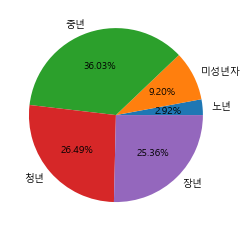

In [46]:
years=titanic.withColumn('연령대',
                            when(titanic['Age']>=60,'노년').\
                            when(titanic['Age']>=35,'장년').\
                            when(titanic['Age']>=25,'중년').\
                            when(titanic['Age']>=15,'청년').\
                            otherwise('미성년자'))
pie_df=years.groupby('연령대').count()

plt.pie(pie_df.toPandas()['count'].values,
        autopct='%.2f%%', 
        labels=pie_df.toPandas()['연령대'].values)

plt.show()